<a href="https://colab.research.google.com/github/astroC86/BERT_AI_Project/blob/main/AIProject4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
# Link for how to download kaggle data to colab

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zm26300","key":"cd1a18eef5831cd93a402c1da90178d7"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [3]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 19% 5.00M/25.7M [00:00<00:01, 12.7MB/s]
100% 25.7M/25.7M [00:00<00:00, 52.3MB/s]


In [4]:
!unzip imdb-dataset-of-50k-movie-reviews.zip  #unzip data 

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [5]:
from sklearn.model_selection import train_test_split
import pandas            as pd

First 10 rows of the DataFrame:


<bound method NDFrame.describe of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

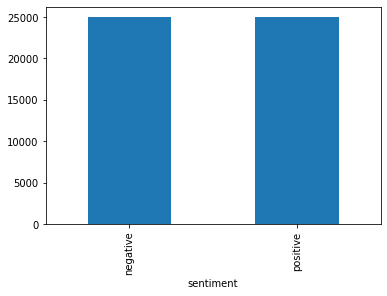

In [35]:
df        = pd.read_csv("IMDB Dataset.csv")
print("First 10 rows of the DataFrame:")
#print(df)

df.groupby(['sentiment']).size().plot.bar()
df.describe

In [7]:
x_org = df.drop(["sentiment"], axis="columns")
y_org = df.drop(["review"], axis="columns")

print('review')
print(x_org)

print('sentiment')
print(y_org)

print("Original training dataset shape:")
print(y_org.squeeze().value_counts())

print("\n\n data is split equaly from the get go")

review
                                                  review
0      One of the other reviewers has mentioned that ...
1      A wonderful little production. <br /><br />The...
2      I thought this was a wonderful way to spend ti...
3      Basically there's a family where a little boy ...
4      Petter Mattei's "Love in the Time of Money" is...
...                                                  ...
49995  I thought this movie did a down right good job...
49996  Bad plot, bad dialogue, bad acting, idiotic di...
49997  I am a Catholic taught in parochial elementary...
49998  I'm going to have to disagree with the previou...
49999  No one expects the Star Trek movies to be high...

[50000 rows x 1 columns]
sentiment
      sentiment
0      positive
1      positive
2      positive
3      negative
4      positive
...         ...
49995  positive
49996  negative
49997  negative
49998  negative
49999  negative

[50000 rows x 1 columns]
Original training dataset shape:
negative    25000
posi

In [8]:
x_train, x_testValidate, y_train, y_testValidate = train_test_split(x_org, y_org,
                                                    test_size=0.30,
                                                    random_state=0,
                                                    stratify=y_org)

x_validate, x_test, y_validate, y_test          = train_test_split(x_testValidate, y_testValidate,
                                                    test_size=(2/3),
                                                    random_state=0,
                                                    stratify=y_testValidate)

print("Positive-Negative split for training")
print(y_train.squeeze().value_counts())

print("\n\nPositive-Negative split for testing")
print(y_test.squeeze().value_counts())

print("\n\nPositive-Negative split for validation")
print(y_validate.squeeze().value_counts())


Positive-Negative split for training
negative    17500
positive    17500
Name: sentiment, dtype: int64


Positive-Negative split for testing
positive    5000
negative    5000
Name: sentiment, dtype: int64


Positive-Negative split for validation
positive    2500
negative    2500
Name: sentiment, dtype: int64


In [20]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from typing_extensions import final
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<.*?>') 


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocess(text):
  texts = re.sub(CLEANR, ' ', text) # reomving html entities
  texts = "".join([char for char in texts if char not in string.punctuation]) # removing punctiuation
  texts = texts.lower() #lowering 
  texts = texts.split(' ')
  texts = [word for word in texts if word not in stop_words] #removing stopwords
  texts = [lemmatizer.lemmatize(word=word,pos='v') for word in texts] #lematizing
  texts = ' '.join(texts)
  return texts

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
pp_x_train         = pd.DataFrame({'review': x_train['review'].apply(preprocess)})
pp_x_testValidate  = pd.DataFrame({'review': x_testValidate['review'].apply(preprocess)})

pp_x_validate = pd.DataFrame({'review': x_validate['review'].apply(preprocess)})
pp_x_test     = pd.DataFrame({'review': x_test ['review'].apply(preprocess)})

pp_y_train   , pp_y_testValidate = y_train,y_testValidate
pp_y_validate, pp_y_test         = y_validate, y_test  

In [32]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
      self.sentiment = df['sentiment'] 
      self.texts     = [tokenizer(text, padding  = 'max_length', 
                                max_length     = 512, 
                                truncation     = True,
                                return_tensors ="pt") for text in df['review']]

    def __len__(self):
        return len(self.labels)

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = np.array(self.labels[idx])
        batch_y     = self.get_batch_labels(idx)
        return batch_texts, batch_y

### **Preparing BERT Model**

In [19]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 11.9 MB/s 
     |████████████████████████████████| 6.8 MB 41.7 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 895 kB 51.9 MB/s 
     |████████████████████████████████| 596 kB 65.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [31]:
EPOCHS         = 50
BATCH_SIZE     = 64
LEARNING_RATE  = 0.001

In [30]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert    = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.l1      = nn.Linear(768, 512)
        self.l2      = nn.Linear(512, 256)
        self.l3      = nn.Linear(256, 64)
        self.l4      = nn.Linear(64, 1)
        self.relu    = nn.ReLU()
    # to reference for possible imporvement
    #https://github.com/huggingface/transformers/issues/1328
    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x                = self.dropout(pooled_output)
        x                = self.dropout(self.relu(self.l1(x)))
        x                = self.dropout(self.relu(self.l2(x)))
        x                = self.dropout(self.relu(self.l3(x)))
        x                = self.dropout(self.relu(self.l4(x)))
        final_layer      = self.relu(x)
        return final_layer

In [ ]:
from tqdm import tqdm


def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [33]:
model     = BertClassifier()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
